In [1]:
import sys, os
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from matplotlib.animation import FuncAnimation
import glob
import pickle


In [6]:
data_path = "/remote/tychodata/ftairli/data/CDE/SpaceTriggerPickles/*"

abs_path = os.path.abspath(data_path)


all_files = sorted(glob.glob(abs_path ))
print(f'Found {len(all_files)} files')
print(all_files)

# Work on only one batch for now
Only_One_Batch = True
if Only_One_Batch:
    all_files = all_files[:1]

print(all_files)

Data = []
for file in all_files:
    with open(file, 'rb') as f:
        data = pickle.load(f)
        Data.extend(data)

Found 46 files
['/remote/tychodata/ftairli/data/CDE/SpaceTriggerPickles/DoSpaceTrigger_Data_Batchb01_low.pkl', '/remote/tychodata/ftairli/data/CDE/SpaceTriggerPickles/DoSpaceTrigger_Data_Batchb02_low.pkl', '/remote/tychodata/ftairli/data/CDE/SpaceTriggerPickles/DoSpaceTrigger_Data_Batchb03_low.pkl', '/remote/tychodata/ftairli/data/CDE/SpaceTriggerPickles/DoSpaceTrigger_Data_Batchb04_low.pkl', '/remote/tychodata/ftairli/data/CDE/SpaceTriggerPickles/DoSpaceTrigger_Data_Batchb05_low.pkl', '/remote/tychodata/ftairli/data/CDE/SpaceTriggerPickles/DoSpaceTrigger_Data_Batchb06_low.pkl', '/remote/tychodata/ftairli/data/CDE/SpaceTriggerPickles/DoSpaceTrigger_Data_Batchb07_low.pkl', '/remote/tychodata/ftairli/data/CDE/SpaceTriggerPickles/DoSpaceTrigger_Data_Batchb08_low.pkl', '/remote/tychodata/ftairli/data/CDE/SpaceTriggerPickles/DoSpaceTrigger_Data_Batchb09_low.pkl', '/remote/tychodata/ftairli/data/CDE/SpaceTriggerPickles/DoSpaceTrigger_Data_Batchb10_low.pkl', '/remote/tychodata/ftairli/data/CD

In [7]:
print(Data[0].keys())
print(Data[0]['PixelData'].keys())

dict_keys(['Batch', 'Shower', 'EyeID', 'Gen_LogE', 'Gen_CosZen', 'Gen_Xmax', 'Gen_SDPPhi', 'Gen_SDPTheta', 'Gen_Chi0', 'Gen_Rp', 'Gen_T0', 'Gen_CoreEyeDist', 'Gen_CherenkovFraction', 'Gen_Primary', 'EventClass', 'TotalPixels', 'PixelData', 'MyyTrigger', 'HillasValues'])
dict_keys(['PixelID', 'Status', 'Theta', 'Phi', 'Trace', 'RecTrigger'])


In [16]:
# Redo the trigger using spatial analysis instead of time box analysis

def threshold_relaxation_coefficient(Guaranteed_Threshold,Neighbour_signals,coefficient_decay = 5.0):
    if type(Neighbour_signals) != np.ndarray: Neighbour_signals = np.array(Neighbour_signals)
    N_Neighbours = len(Neighbour_signals)
    # fractional_neighbour_signals = Neighbour_signals/Guaranteed_Threshold


    coefficient = np.exp(-coefficient_decay*np.sum(Neighbour_signals)/N_Neighbours)
    return max(0,coefficient)


def ReTriggerEvent(Event):
    # Extract the relevant data from the event

    N_pixels = Event['TotalPixels']

    PixelData = Event['PixelData']
    pix_Theta = PixelData['Theta']
    pix_Phi = PixelData['Phi']
    pix_Trace = PixelData['Trace']
    pix_RecTrigger = PixelData['RecTrigger']

    pix_MyyTrigger = np.zeros_like(pix_RecTrigger)

    trace_length = pix_Trace.shape[1]

    # First Construct the neighbour map
    neighbours_list = np.zeros((N_pixels,N_pixels), dtype=bool)
    for i_pix in range(N_pixels):
        for j_pix in range(N_pixels):
            if i_pix == j_pix: continue
            pix_distance = np.sqrt( (pix_Theta[i_pix]-pix_Theta[j_pix])**2 + (pix_Phi[i_pix]-pix_Phi[j_pix])**2 )
            if pix_distance < 2.0:  # degrees
                neighbours_list[i_pix,j_pix] = True
    

                
    # Now we can find the approximate trigger window from the RecTrigger
    triggered_positions = np.where(pix_RecTrigger)[1]
    if triggered_positions.size > 0:
        min_pos = np.min(triggered_positions)
        max_pos = np.max(triggered_positions)
    else:
        min_pos = 0
        max_pos = 99999
    min_pos = max(0,min_pos-5)
    max_pos = min(trace_length,max_pos+10)

    
    Norm_Signal_Array  = pix_Trace / np.std(pix_Trace[:,:200].astype(np.float64), axis=1, keepdims=True)
    # print(f'Normed Signal Array : {Norm_Signal_Array}')
    GuaranteedThreshold = 5 # In units of std deviations

    # Now go over each time bin and ReTrigger
    for t in range(min_pos, max_pos+1):
        signals = Norm_Signal_Array[:,t]
        # print(f"Time bin {t}, Signals: {signals}")
        for i_pix in range(N_pixels):
            # print(f'Checking Singal {signals[i_pix]:.2f} for pixel {i_pix} at time {t}')
            if signals[i_pix] > GuaranteedThreshold:
                pix_MyyTrigger[i_pix,t] = True
                continue

            neighbour_indices = np.where(neighbours_list[i_pix])[0]
            neighbour_signals = signals[neighbour_indices]
            neighbour_signals = np.clip(neighbour_signals, -GuaranteedThreshold, GuaranteedThreshold)

            relative_threshold = GuaranteedThreshold * threshold_relaxation_coefficient(GuaranteedThreshold, neighbour_signals)
            if signals[i_pix] > relative_threshold:
                pix_MyyTrigger[i_pix,t] = True
                
    
    # Now we must prune the trigger 

    # First we make sure that once triggered, a pixel stays triggered for at least 3 time bins
    for i_pix in range(N_pixels):
        triggered_times = np.where(pix_MyyTrigger[i_pix])[0]
        # print(f"Pixel {i_pix} initially triggered at times: {triggered_times}")
        for t in triggered_times:
            trigger_bins = pix_MyyTrigger[i_pix, max(0,t-2):min(trace_length,t+3)]
            if len(trigger_bins) < 5: continue
            elif (np.sum(trigger_bins[0:3]) == 3) or (np.sum(trigger_bins[1:4]) == 3) or (np.sum(trigger_bins[2:5]) == 3): continue
            else: 
                # print(f"Pruning pixel {i_pix} at time {t} for not having 3 consecutive triggers.")
                pix_MyyTrigger[i_pix, t] = False
        # print(f"Pixel {i_pix} finally triggered at times: {np.where(pix_MyyTrigger[i_pix])[0]}")
    # Other Prunning Steps are not added yet

    # Second we make sure that the triggered pixels are all contiguous.
    # To do that, we will use the neighbours map to find pixels connected to the one with the highest signal

    Triggered_at_any_time = np.where(np.any(pix_MyyTrigger, axis=1))[0]
    highest_Signal_pix = np.where(pix_Trace == np.max(pix_Trace))[0]
    
    # using BFS we visit neighbours of triggered pixels
    Is_Safe_map = np.zeros(N_pixels,dtype=bool)

    queue = [highest_Signal_pix[0]]
    while queue:
        current_pix = queue.pop(0)
        if Is_Safe_map[current_pix]: continue
        Is_Safe_map[current_pix] = True
        neighbour_indices = np.where(neighbours_list[current_pix])[0]
        for neighbour in neighbour_indices:
            if neighbour in Triggered_at_any_time and not Is_Safe_map[neighbour]:
                queue.append(neighbour)
    # Now make everything not in Is_Safe_map False in the trigger map
    for i_pix in range(N_pixels):
        if not Is_Safe_map[i_pix]:
            pix_MyyTrigger[i_pix,:] = False

    Event['MyyTrigger'] = pix_MyyTrigger

    

Text(0.7, 0.8, 'Mean: 19.42\nStd: 13.60')

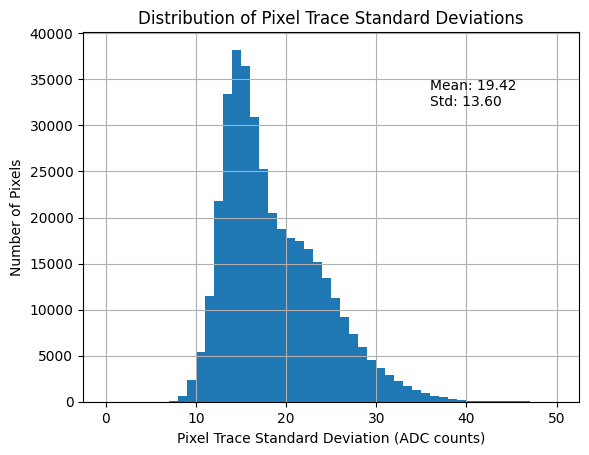

In [8]:
# Lets check pix standard deviations
stds = []
for i, Event in enumerate(Data):
    PixelData = Event['PixelData']
    pix_Trace = PixelData['Trace']
    pix_stds = np.std(pix_Trace[:,:200].astype(np.float64), axis=1)
    stds.extend(pix_stds)

std = np.array(stds)
plt.figure()
plt.hist(std, bins=50, range=(0,50))
plt.xlabel('Pixel Trace Standard Deviation (ADC counts)')
plt.ylabel('Number of Pixels')
plt.title('Distribution of Pixel Trace Standard Deviations')
plt.grid()
plt.text(0.7, 0.8, f'Mean: {np.mean(std):.2f}\nStd: {np.std(std):.2f}', transform=plt.gca().transAxes)

In [17]:
for i,Event in enumerate(Data):
    print(f"ReTriggering event {i+1}/{len(Data)}", end='\r')
    ReTriggerEvent(Event)
print("\nFinished ReTriggering all events.")


/tmp/ipykernel_2912/4067245721.py:9: RuntimeWarning: invalid value encountered in double_scalars
  coefficient = np.exp(-coefficient_decay*np.sum(Neighbour_signals)/N_Neighbours)


ReTriggering event 3495/3495
Finished ReTriggering all events.


[597 598 599 600 601 602 603 604 605 606 607 608 597 598 599 600 601 602
 603 597 598 599 600 601 602 603 604 605 606 594 595 596 597 598 599 600
 601 602 603 604 595 596 597 598 599 600 601 602 603 599 600 601 602 603
 604 605 606 597 598 599 600 601 602 603 604 605 598 599 600 601 602 603
 604 605 606 607 608 595 596 597 598 599 600 601 602 603 604 605 606 607
 599 600 601 602 603 604 605 606 607 600 601 602 603 604 605 606 607 600
 601 602 603 604 605 606 607 600 601 602 603 604 605 606 607]
Animating event Batch: 300000011, shower 2774, time bins 591 to 611


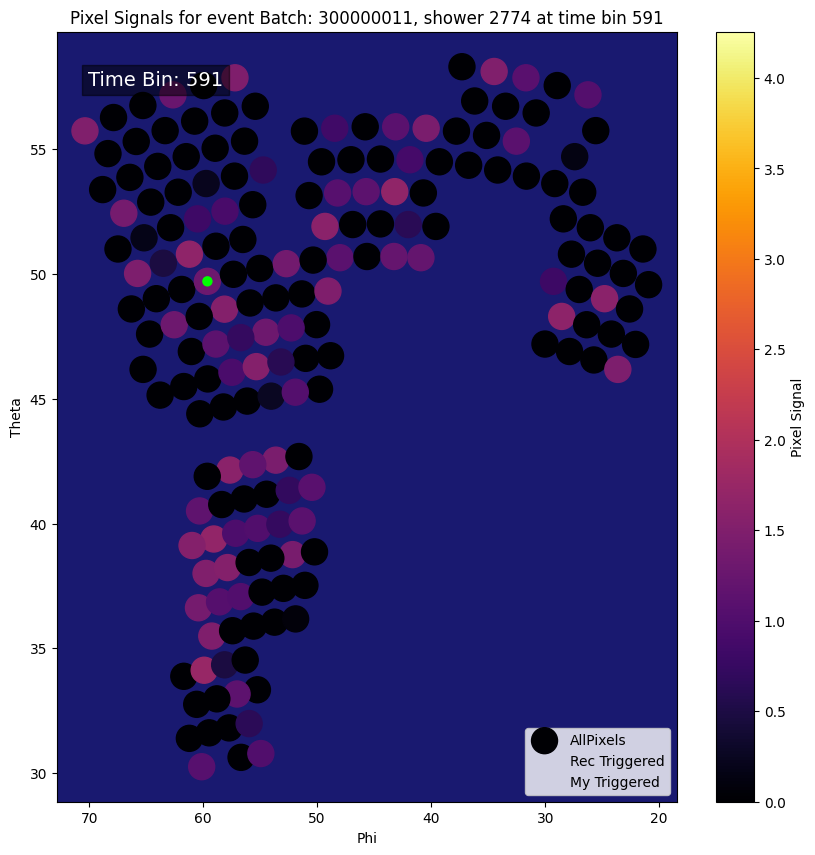

In [20]:
# Now lets plot this new trigger in the animation
# Make the Plot

EventIndex = 13
Event = Data[EventIndex]



set_std_norm_for_all = False
plot_log_scale = True


Pos_array = np.array( list( zip(Event['PixelData']['Phi'], Event['PixelData']['Theta']) ) )
Signal_array = Event['PixelData']['Trace']
Rec_Trigger_array = Event['PixelData']['RecTrigger']
My_Trigger_array = Event['MyyTrigger']
N_pixels_in_event = Event['TotalPixels']
trace_length = Signal_array.shape[1]

# Now we can find the approximate trigger window from the RecTrigger
triggered_positions = np.where(Rec_Trigger_array)[1]
print(triggered_positions)
if triggered_positions.size > 0:
    min_pos = np.min(triggered_positions)
    max_pos = np.max(triggered_positions)
else:
    min_pos = 0
    max_pos = 99999
min_pos = max(0,min_pos-3)
max_pos = min(trace_length,max_pos+3)

print(f"Animating event Batch: {Event['Batch']}, shower {Event['Shower']}, time bins {min_pos} to {max_pos}")

fig, ax = plt.subplots(figsize=(10, 10))
if set_std_norm_for_all:
    select_vmax = 5
    select_vmin = 0
elif plot_log_scale:
    select_vmax = np.log10(18000)
    select_vmin = 0
else:
    select_vmax = 500
    select_vmin = 0

scat = ax.scatter(Pos_array[:,0], Pos_array[:,1],
                    cmap='inferno',c = np.log10(np.clip(Signal_array[:,min_pos],a_min=1,a_max=None)),
                    s=350, label='AllPixels', alpha=1,
                    vmin = select_vmin, vmax = select_vmax)

# Plot red cross at triggered pixels at this time bin
rec_trigger_alpha = (Rec_Trigger_array[:,min_pos]*0.8).astype(float)
rec_triggered = ax.scatter(Pos_array[:,0], Pos_array[:,1], alpha = rec_trigger_alpha,
                            s=50, label='Rec Triggered', facecolors='none', c=['cyan']*N_pixels_in_event, linewidths=2,marker='x')

my_trigger_alpha = (My_Trigger_array[:,min_pos]).astype(float)
my_triggered = ax.scatter(Pos_array[:,0], Pos_array[:,1], alpha = my_trigger_alpha,
                            s=30, label='My Triggered', c = ['lime']*N_pixels_in_event, linewidths=2, marker='o')

# Bin Label Text
bin_text = ax.text(0.05, 0.95, f'Time Bin: {min_pos}', transform=ax.transAxes, fontsize=14,
                    verticalalignment='top', color='white', bbox=dict(facecolor='black', alpha=0.5))

ax.set_xlabel('Phi')
ax.set_ylabel('Theta')
ax.set_title(f"Pixel Signals for event Batch: {Event['Batch']}, shower {Event['Shower']} at time bin {min_pos}")
ax.set_facecolor('midnightblue')
plt.colorbar(scat, label='Pixel Signal')
plt.legend()

# Set Limits here if needed
# ax.set_xlim([-1.5,1.5])
# ax.set_ylim([-1.5,1.5])
ax.invert_xaxis()

# Construct the animation updates

def update(frame):
    if not plot_log_scale : signals = Signal_array[:, frame]
    elif set_std_norm_for_all : signals = Signal_array[:, frame] / np.std(Signal_array[:,:200], axis=1)
    else : signals = signals = np.log10(np.clip(Signal_array[:,frame], a_min=1, a_max=None))
    
    scat.set_array(signals)
    bin_text.set_text(f'Time Bin: {frame}')

    rec_trigger_alpha = (Rec_Trigger_array[:,frame]*0.8).astype(float)
    rec_triggered.set_alpha(rec_trigger_alpha)
    my_trigger_alpha = (My_Trigger_array[:,frame]).astype(float)
    my_triggered.set_alpha(my_trigger_alpha)

    return scat, bin_text, rec_triggered

ani = FuncAnimation(
    fig, update, frames=range(min_pos, max_pos + 1),
    interval=500, blit=False, repeat=True
)
# ani.save('trigger_animation.gif', writer='pillow', fps=2)
plt.show()



In [57]:
# Now lets do stats

Rec_Trigger_Duration = []
Myy_Trigger_Duration = []

Rec_Trigger_Multiplicity = []
Myy_Trigger_Multiplicity = []

Gen_LogE = []
Gen_Xmax = []
Gen_Chi0 = []
Gen_Rp   = []
Gen_Primary = []
Gen_EventClass = []
Gen_Cherenkov_Fraction = []

Collect_All_Batches = True
if not Collect_All_Batches:
    for i,Event in enumerate(Data):
        print(f"Calculating stats for event {i+1}/{len(Data)}", end='\r')
        Rec_Trigger = Event['PixelData']['RecTrigger']
        Myy_Trigger = Event['MyyTrigger']

        # Duration
        triggered_positions_Rec = np.where(Rec_Trigger)[1]
        if triggered_positions_Rec.size > 0:
            min_pos_Rec = np.min(triggered_positions_Rec)
            max_pos_Rec = np.max(triggered_positions_Rec)
            duration_Rec = max_pos_Rec - min_pos_Rec + 1
        else:
            duration_Rec = 0
        Rec_Trigger_Duration.append(duration_Rec)

        triggered_positions_Myy = np.where(Myy_Trigger)[1]
        if triggered_positions_Myy.size > 0:
            min_pos_Myy = np.min(triggered_positions_Myy)
            max_pos_Myy = np.max(triggered_positions_Myy)
            duration_Myy = max_pos_Myy - min_pos_Myy + 1
        else:
            duration_Myy = 0
        Myy_Trigger_Duration.append(duration_Myy)

        # Multiplicity
        multiplicity_Rec = np.sum(np.any(Rec_Trigger, axis=1))
        Rec_Trigger_Multiplicity.append(multiplicity_Rec)

        multiplicity_Myy = np.sum(np.any(Myy_Trigger, axis=1))
        Myy_Trigger_Multiplicity.append(multiplicity_Myy)

        # Gen info
        Gen_LogE.append(Event['Gen_LogE'])
        Gen_Xmax.append(Event['Gen_Xmax'])
        Gen_Chi0.append(Event['Gen_Chi0'])
        Gen_Rp  .append(Event['Gen_Rp'])
        Gen_Primary.append(Event['Gen_Primary'])
        Gen_EventClass.append(Event['EventClass'])
        Gen_Cherenkov_Fraction.append(Event['Gen_CherenkovFraction'])

Rec_Trigger_Duration = np.array(Rec_Trigger_Duration)
Myy_Trigger_Duration = np.array(Myy_Trigger_Duration)

Rec_Trigger_Multiplicity = np.array(Rec_Trigger_Multiplicity)
Myy_Trigger_Multiplicity = np.array(Myy_Trigger_Multiplicity)

Gen_LogE = np.array(Gen_LogE)
Gen_Xmax = np.array(Gen_Xmax)
Gen_Chi0 = np.array(Gen_Chi0)
Gen_Rp   = np.array(Gen_Rp)
Gen_Primary = np.array(Gen_Primary)
Gen_EventClass = np.array(Gen_EventClass)
Gen_Cherenkov_Fraction = np.array(Gen_Cherenkov_Fraction)

    

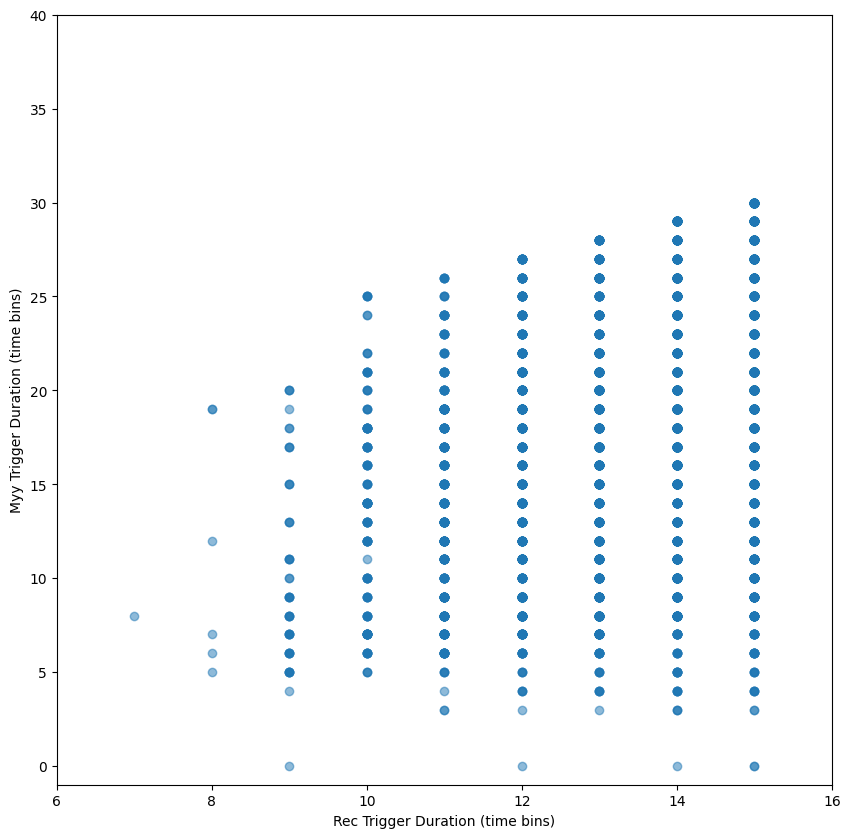

In [27]:
plt.figure(figsize = [10,10])
plt.scatter(Rec_Trigger_Duration, Myy_Trigger_Duration, alpha=0.5)
plt.xlabel('Rec Trigger Duration (time bins)')
plt.ylabel('Myy Trigger Duration (time bins)')
plt.xlim(6,16)
plt.ylim(-1,40)
plt.show()

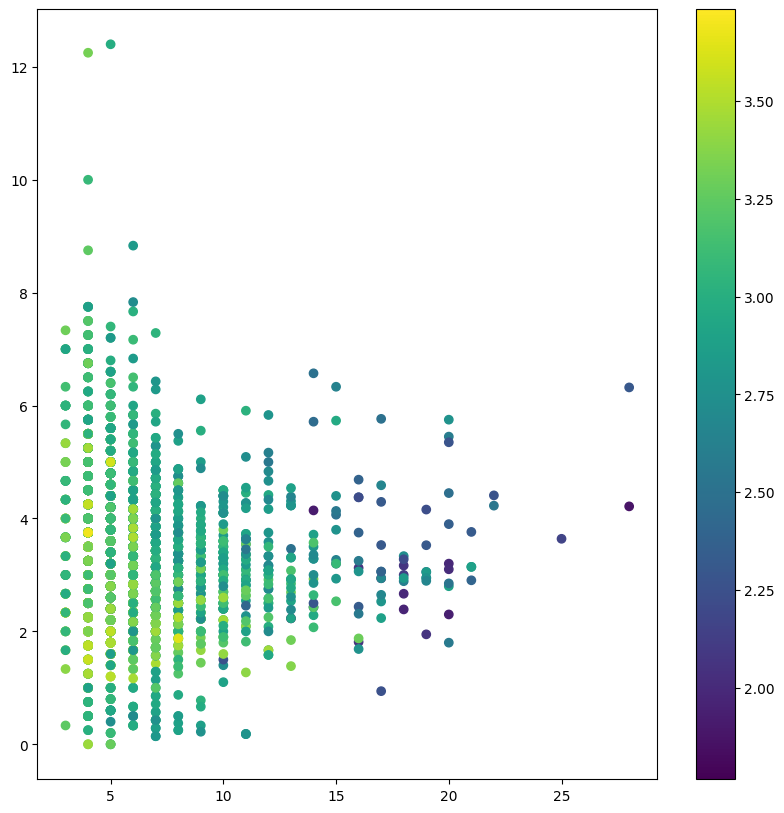

In [28]:
plt.figure(figsize = [10,10])
plt.scatter(Rec_Trigger_Multiplicity, Myy_Trigger_Multiplicity/Rec_Trigger_Multiplicity,c = np.log10(Gen_Rp))
plt.colorbar()

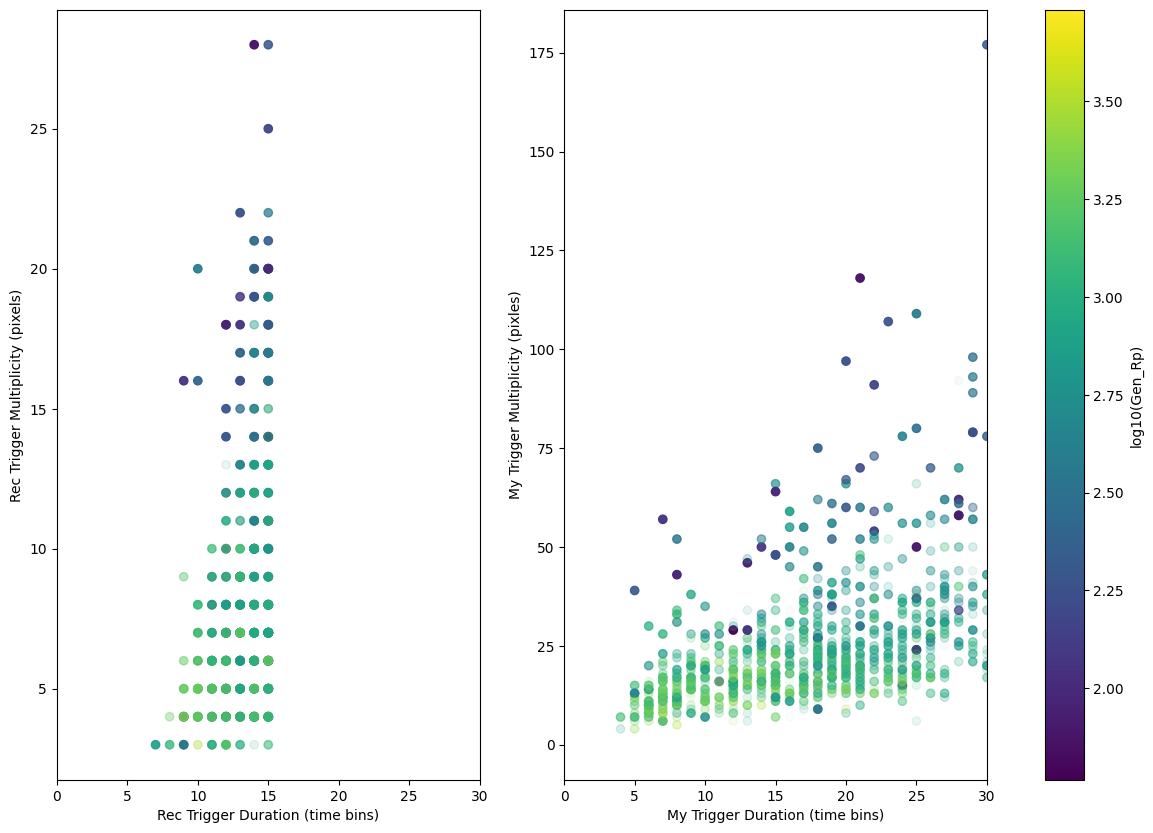

In [44]:
fig,ax = plt.subplots(1,2, figsize = [15,10])
CF_limit = 95
CF_scale = 100-CF_limit

Alpha = Gen_Cherenkov_Fraction-CF_limit
Alpha = np.clip(Alpha,0,CF_scale)/CF_scale

ax[0].scatter(Rec_Trigger_Duration, Rec_Trigger_Multiplicity, c = np.log10(Gen_Rp), alpha=Alpha)
ax[1].scatter(Myy_Trigger_Duration, Myy_Trigger_Multiplicity, c = np.log10(Gen_Rp), alpha=Alpha)
plt.colorbar(ax[1].collections[0], ax=ax, label='log10(Gen_Rp)')

ax[0].set_xlabel('Rec Trigger Duration (time bins)')
ax[0].set_ylabel('Rec Trigger Multiplicity (pixels)')
ax[1].set_xlabel('My Trigger Duration (time bins)')
ax[1].set_ylabel('My Trigger Multiplicity (pixles)')

ax[0].set_xlim(0,30)
ax[1].set_xlim(0,30)
plt.show()

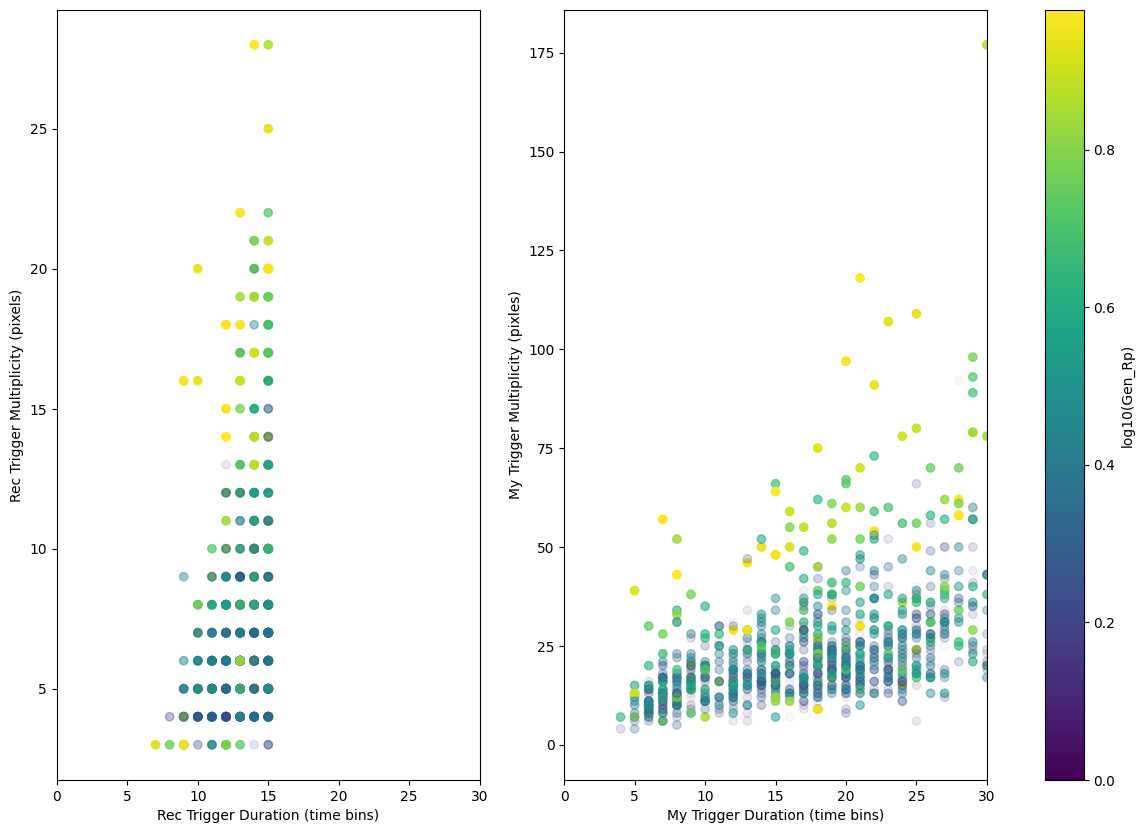

In [45]:
fig,ax = plt.subplots(1,2, figsize = [15,10])
CF_limit = 95
CF_scale = 100-CF_limit

Alpha = Gen_Cherenkov_Fraction-CF_limit
Alpha = np.clip(Alpha,0,CF_scale)/CF_scale

ax[0].scatter(Rec_Trigger_Duration, Rec_Trigger_Multiplicity, c = Alpha, alpha=Alpha)
ax[1].scatter(Myy_Trigger_Duration, Myy_Trigger_Multiplicity, c = Alpha, alpha=Alpha)
plt.colorbar(ax[1].collections[0], ax=ax, label='log10(Gen_Rp)')

ax[0].set_xlabel('Rec Trigger Duration (time bins)')
ax[0].set_ylabel('Rec Trigger Multiplicity (pixels)')
ax[1].set_xlabel('My Trigger Duration (time bins)')
ax[1].set_ylabel('My Trigger Multiplicity (pixles)')

ax[0].set_xlim(0,30)
ax[1].set_xlim(0,30)
plt.show()

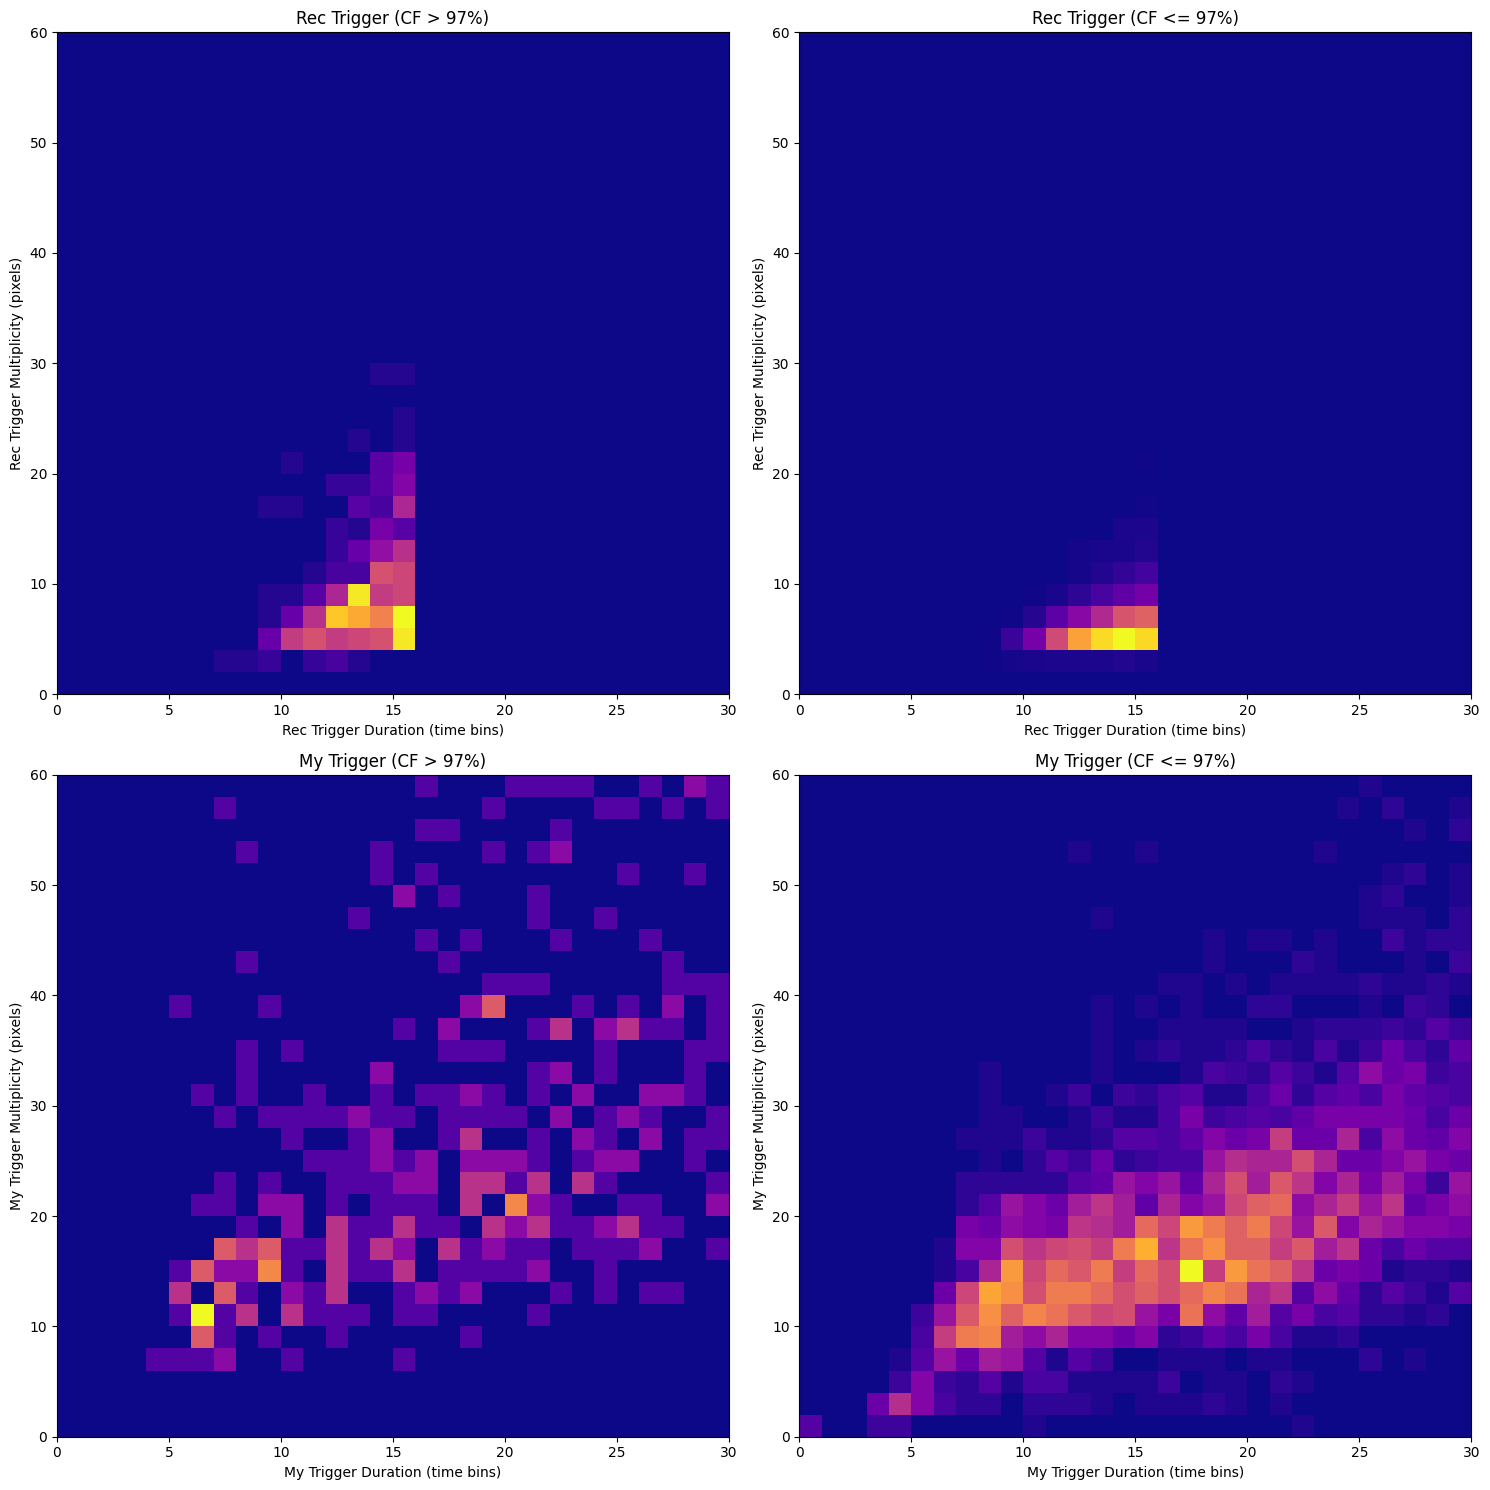

In [61]:
fig, ax = plt.subplots(2,2, figsize = [15,15])

CF_Cut = 97
Mask = Gen_Cherenkov_Fraction > CF_Cut

ax[0,0].hist2d(Rec_Trigger_Duration[Mask], Rec_Trigger_Multiplicity[Mask], bins=30, range=[[0,30],[0,60]], cmap='plasma')
ax[0,0].set_xlabel('Rec Trigger Duration (time bins)')
ax[0,0].set_ylabel('Rec Trigger Multiplicity (pixels)')
ax[0,0].set_title(f'Rec Trigger (CF > {CF_Cut}%)')

ax[0,1].hist2d(Rec_Trigger_Duration[~Mask], Rec_Trigger_Multiplicity[~Mask], bins=30, range=[[0,30],[0,60]], cmap='plasma')
ax[0,1].set_xlabel('Rec Trigger Duration (time bins)')
ax[0,1].set_ylabel('Rec Trigger Multiplicity (pixels)')
ax[0,1].set_title(f'Rec Trigger (CF <= {CF_Cut}%)')

ax[1,0].hist2d(Myy_Trigger_Duration[Mask], Myy_Trigger_Multiplicity[Mask], bins=30, range=[[0,30],[0,60]], cmap='plasma')
ax[1,0].set_xlabel('My Trigger Duration (time bins)')
ax[1,0].set_ylabel('My Trigger Multiplicity (pixels)')
ax[1,0].set_title(f'My Trigger (CF > {CF_Cut}%)')

ax[1,1].hist2d(Myy_Trigger_Duration[~Mask], Myy_Trigger_Multiplicity[~Mask], bins=30, range=[[0,30],[0,60]], cmap='plasma')
ax[1,1].set_xlabel('My Trigger Duration (time bins)')
ax[1,1].set_ylabel('My Trigger Multiplicity (pixels)')
ax[1,1].set_title(f'My Trigger (CF <= {CF_Cut}%)')

plt.tight_layout()
plt.show()